In [1]:
!git clone https://github.com/Stability-AI/StableCascade.git

Cloning into 'StableCascade'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 253 (delta 72), reused 40 (delta 40), pack-reused 140
Receiving objects: 100% (253/253), 119.02 MiB | 9.88 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [2]:
!cd StableCascade/models && ./download_models.sh essential big-big bfloat16

stage_a.safetensors 100%[===================>]  70.24M  11.2MB/s    in 6.3s    
previewer.safetenso 100%[===================>]  15.21M  10.7MB/s    in 1.4s    
effnet_encoder.safe 100%[===================>]  77.73M  11.2MB/s    in 7.0s    
stage_b_bf16.safete 100%[===================>]   2.91G  11.2MB/s    in 4m 33s  
stage_c_bf16.safete 100%[===================>]   6.68G  11.2MB/s    in 10m 25s 


In [3]:
!cd StableCascade/inference/ && wget https://huggingface.co/dome272/stable-cascade/resolve/main/imagenet_1024.tar -P inference -q --show-progress

imagenet_1024.tar   100%[===================>]  20.62M  10.8MB/s    in 1.9s    


In [4]:
import os
os.chdir('StableCascade')
import yaml
import torch
from tqdm import tqdm
from inference.utils import *
from core.utils import load_or_fail
from train import WurstCoreB
from scipy.stats import norm

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config_file_b = 'configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core = WurstCoreB(config_dict=config_file_b, device=device, training=False)
extras = core.setup_extras_pre()
data = core.setup_data(extras)
models = core.setup_models(extras)
models.generator.bfloat16();

['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']
Training with batch size 4 (4/GPU)
['dataset', 'dataloader', 'iterator']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']


In [6]:
extras.sampling_configs['cfg'] = 1.1
extras.sampling_configs['shift'] = 1
extras.sampling_configs['timesteps'] = 10
extras.sampling_configs['t_start'] = 1.0

In [7]:
def compress(batch):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
        factor = 3/4
        scaled_image = downscale_images(batch['images'], factor)
        effnet_latents = models.effnet(extras.effnet_preprocess(scaled_image.to(device)))
        
        # u = norm.cdf(effnet_latents.detach().cpu())
        # q = (16*u - 0.5).round()
        # effnet_latents = torch.tensor(q).cuda()
        
        conditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False)
        unconditions = core.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True)    
        conditions['effnet'] = effnet_latents
        unconditions['effnet'] = torch.zeros_like(effnet_latents)
        return conditions, unconditions

In [8]:
def decompress(conditions, unconditions):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
        # effnet_latents = conditions['effnet'].detach().cpu()
        # r = (c+0.5)/16
        # r = norm.ppf(r)
        # effnet_latents = torch.tensor(r).cuda()
        # conditions['effnet'] = effnet_latents
    
        sampling_b = extras.gdf.sample(
            models.generator, conditions, (batch['images'].size(0), 4, batch['images'].size(-2)//4, batch['images'].size(-1)//4),
            unconditions, device=device, **extras.sampling_configs
        )
        for (sampled_b, _, _) in tqdm(sampling_b, total=extras.sampling_configs['timesteps']):
            sampled_b = sampled_b
        sampled = models.stage_a.decode(sampled_b).float()
        return sampled

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


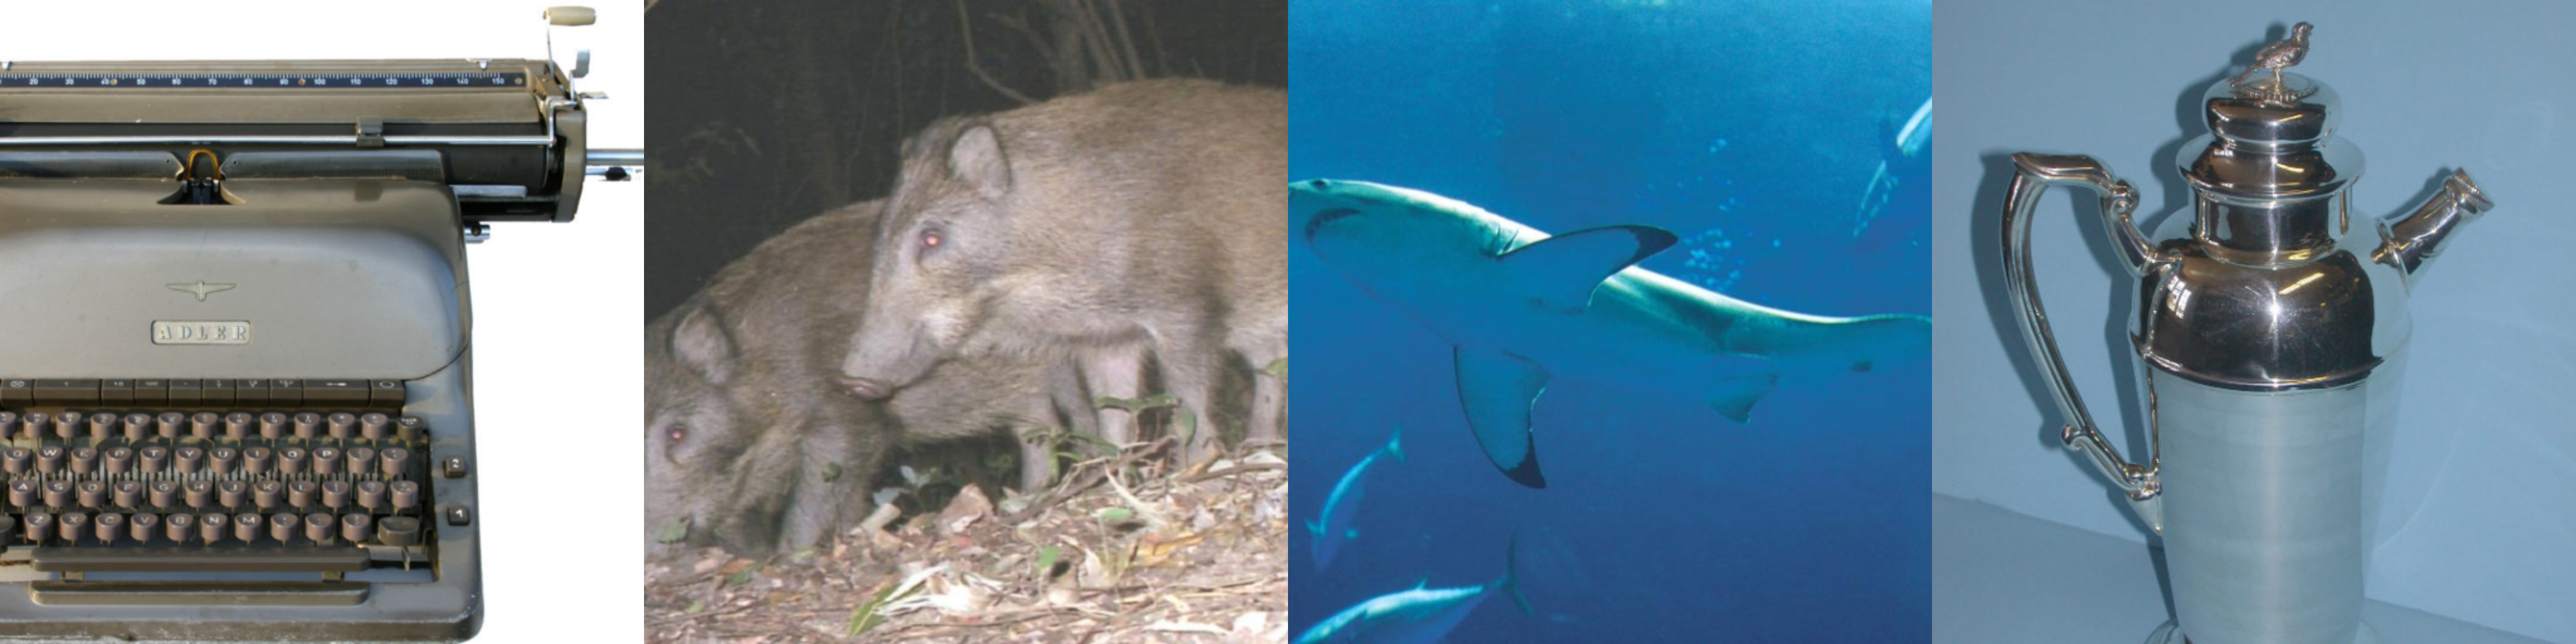

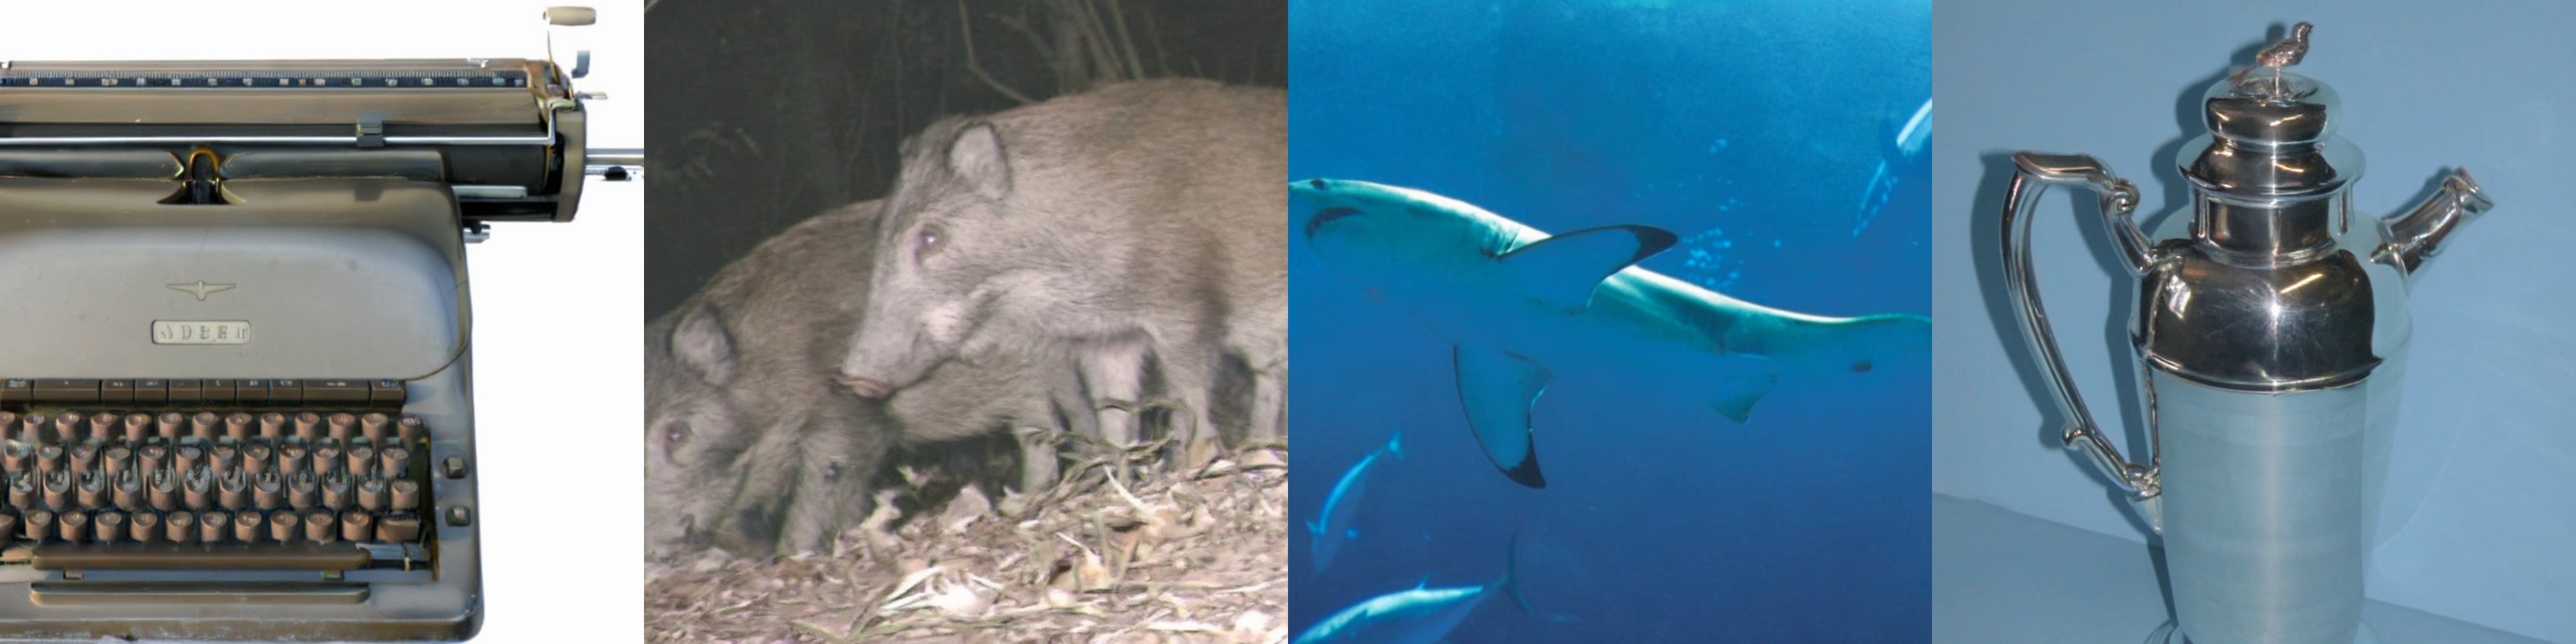

In [9]:
batch = next(data.iterator)
c,u = compress(batch)
r = decompress(c,u)
show_images(batch['images'])
show_images(r)